# Rerank Evaluation

In [1]:
from trectools import TrecQrel, TrecRun, TrecEval
import pandas as pd
import seaborn as sns

SCRAMBLING_APPROACHES = ['nounphrase','tf-idf', 'hbc', 'arampatzis', 'HbcTfIdf', 'arampatzisHbc']
RETRIEVAL_MODELS = ['bm25', 'qld']
SELECTION_STRATEGIES = ['ndcg', 'pmi']

RUN_DIR='/mnt/ceph/storage/data-in-progress/data-research/web-search/private-web-search-with-keyqueries/reranking-index-anserini/'

In [2]:
qrels = TrecQrel('../resources/topics-and-qrels/qrels.cw-private.txt')

In [3]:
df = []

for rtr in RETRIEVAL_MODELS:
    for stn in SELECTION_STRATEGIES:
        for scr in SCRAMBLING_APPROACHES:
            for top_docs in [10, 100]:
                for num_queries in [5, 10, 25]:
                    approach_name = scr + '-' + rtr + '-' + stn + '-' + str(top_docs) + 'top_docs' + '-' + str(num_queries) + 'num_queries'
                    run = TrecRun(RUN_DIR + approach_name + '/' + approach_name + '.txt')
                    te = TrecEval(run, qrels)
                    
                    df += [{
                        'scrambling_retrieval_model': rtr,
                        'query_selection_strategy': stn,
                        'scrambling_approach': scr,
                        'retrieved_docs': top_docs,
                        'num_queries': num_queries,
                        'precision@5': te.get_precision(depth=5, removeUnjudged=True),
                        'precision@10': te.get_precision(depth=10, removeUnjudged=True),
                        'ndcg@5': te.get_ndcg(depth=5, removeUnjudged=True),
                        'ndcg@10': te.get_ndcg(depth=10, removeUnjudged=True),
                    }]

df = pd.DataFrame(df)

In [26]:
def b(measure, query_selection_strategy, scrambling_approach, retrieved_docs, scrambling_retrieval_model, num_queries):
    ret = df[(df['scrambling_approach'] == scrambling_approach) & (df['scrambling_retrieval_model'] == scrambling_retrieval_model) & (df['query_selection_strategy'] == query_selection_strategy) & (df['retrieved_docs'] == retrieved_docs)  & (df['num_queries'] == num_queries)]
    if len(ret) != 1:
        raise ValueError('TBD')
    
    prec = ret.iloc[0][measure]
    
    ret = df_recall[(df_recall['Scrambling Approach'] == scrambling_approach) & (df_recall['Scrambling Retrieval Model'] == scrambling_retrieval_model) & (df_recall['Selection of Queries'] == query_selection_strategy) & (df_recall['docs_retrieved'] == retrieved_docs) & (df_recall['num_queries'] == num_queries)]
    if len(ret) != 1:
        raise ValueError('TBD')
    
    return '{:.2f}'.format(ret.iloc[0]['relevant_docs_retrieved']) + ' & ' + '{:.2f}'.format(prec)

b('precision@10', 'ndcg', 'tf-idf', 100, 'bm25', 25)


def rows(selection, retrieved_docs):
    for rm in RETRIEVAL_MODELS:
        for d,k in [('Sliding Window', 'arampatzis'), ('\\phantom{00}+ HBC', 'arampatzisHbc'), ('TF-IDF', 'tf-idf'), ('\\phantom{00}+ HBC', 'HbcTfIdf'), ('Noun Phrase', 'nounphrase'), ('\\phantom{00}+ HBC', 'hbc')]:
            print ('& ' + d + ' & ' + b('precision@10', selection, k, retrieved_docs, rm, 5) + ' & ' + b('precision@10', selection, k, retrieved_docs, rm, 25) + '\\\\\n')

rows('pmi', 100)

& Sliding Window & 0.34 & 0.03 & 1.79 & 0.13\\

& \phantom{00}+ HBC & 0.69 & 0.06 & 5.89 & 0.29\\

& TF-IDF & 3.52 & 0.22 & 7.31 & 0.34\\

& \phantom{00}+ HBC & 3.54 & 0.23 & 8.67 & 0.35\\

& Noun Phrase & 2.49 & 0.16 & 3.77 & 0.23\\

& \phantom{00}+ HBC & 3.30 & 0.20 & 4.49 & 0.24\\

& Sliding Window & 0.36 & 0.03 & 1.23 & 0.09\\

& \phantom{00}+ HBC & 0.56 & 0.05 & 3.33 & 0.19\\

& TF-IDF & 2.75 & 0.16 & 6.23 & 0.28\\

& \phantom{00}+ HBC & 2.56 & 0.16 & 6.51 & 0.30\\

& Noun Phrase & 2.66 & 0.16 & 4.11 & 0.22\\

& \phantom{00}+ HBC & 2.70 & 0.17 & 4.28 & 0.22\\



# Precision@5

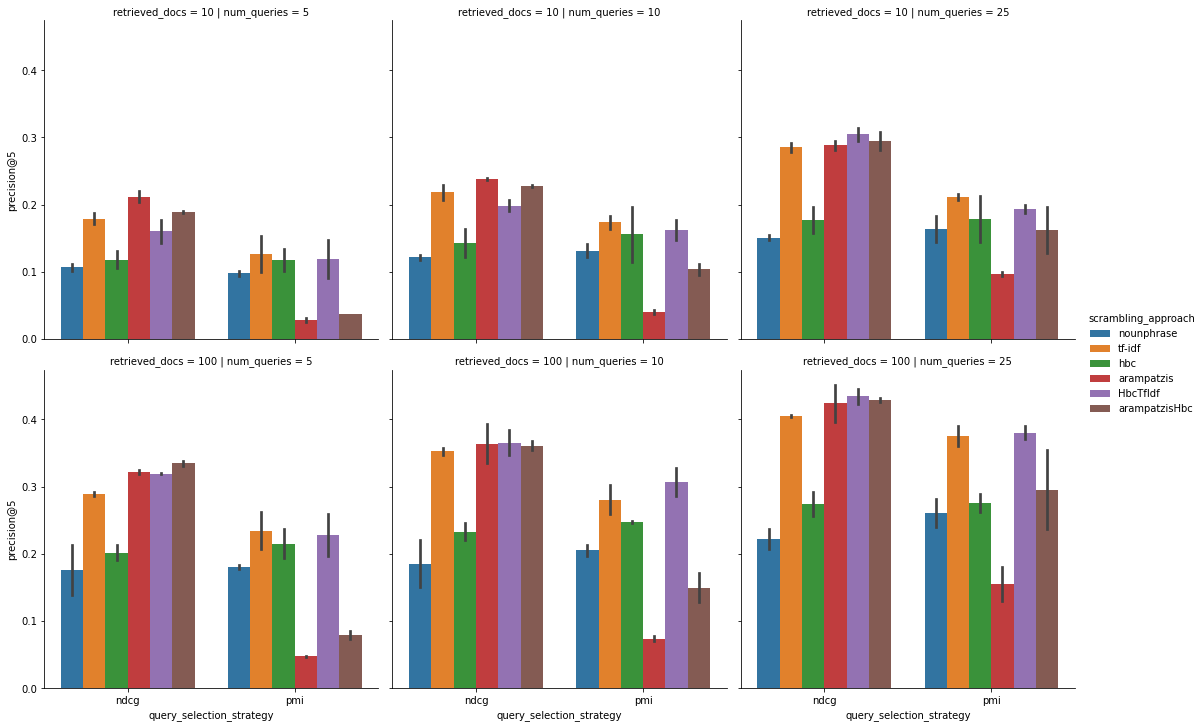

In [10]:
sns.catplot(data=df[(df['query_selection_strategy'] == 'ndcg') | (df['query_selection_strategy'] == 'pmi')],  x='query_selection_strategy', y='precision@5', col='num_queries', hue='scrambling_approach', row='retrieved_docs', kind='bar')

# Table Retrieval Performance

In [20]:
df_recall = pd.read_json('/mnt/ceph/storage/data-in-progress/data-research/web-search/private-web-search-with-keyqueries/scrambling-on-anserini/recall-for-topics.jsonl')
df_recall

,Selection of Queries,docs_retrieved,Scrambling Approach,Scrambling Retrieval Model,num_queries,relevant_docs_retrieved
0,ndcg,100,arampatzisHbc,bm25,25,11.852459
1,ndcg,100,arampatzisHbc,qld,25,10.967213
2,ndcg,100,arampatzis,bm25,25,10.704918
3,ndcg,100,arampatzis,qld,25,9.393443
4,ndcg,100,arampatzisHbc,bm25,10,8.688525
...,...,...,...,...,...,...
139,pmi,10,arampatzisHbc,bm25,5,0.196721
140,pmi,10,arampatzisHbc,qld,5,0.196721
141,pmi,10,arampatzis,qld,10,0.180328
142,pmi,10,arampatzis,bm25,5,0.147541


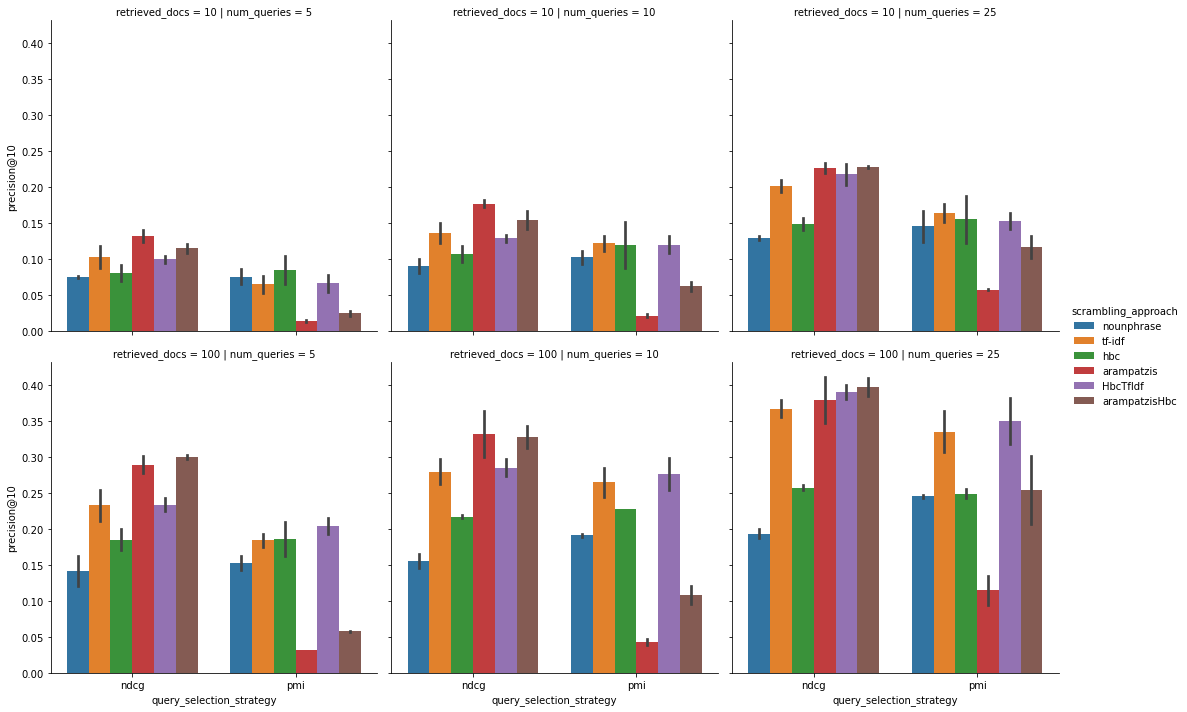

In [29]:
sns.catplot(data=df[(df['query_selection_strategy'] == 'ndcg') | (df['query_selection_strategy'] == 'pmi')],  x='query_selection_strategy', y='precision@10', col='num_queries', hue='scrambling_approach', row='retrieved_docs', kind='bar')

# NDCG@5

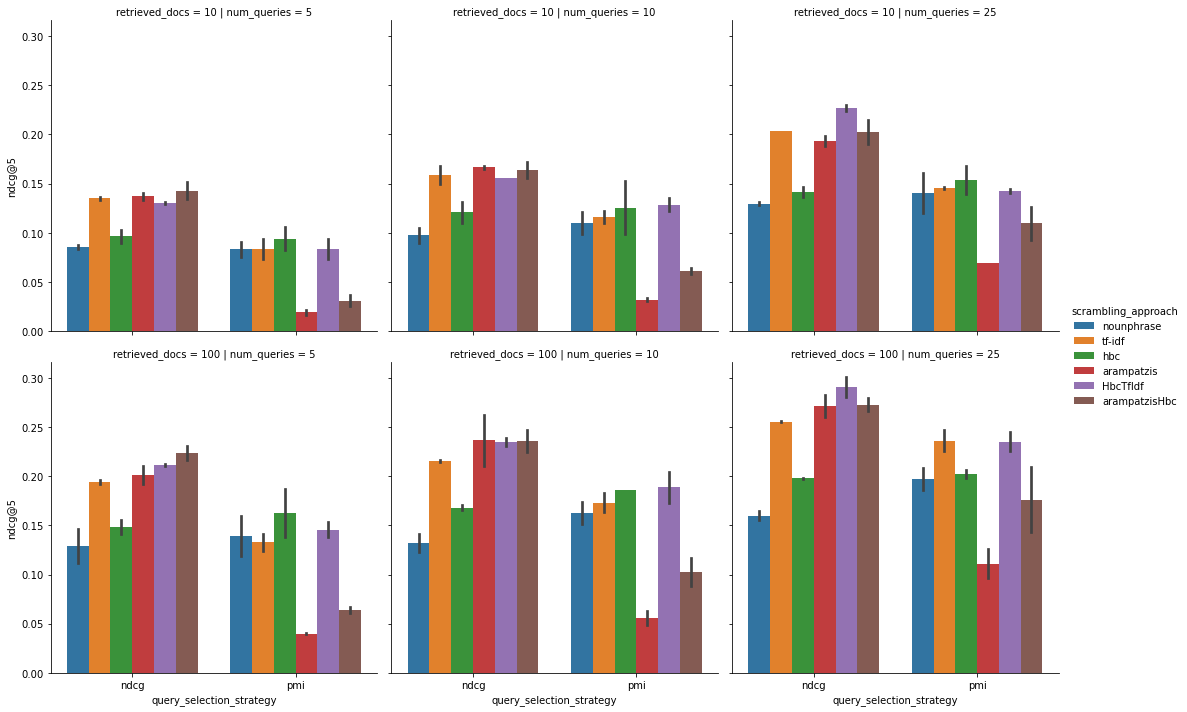

In [23]:
sns.catplot(data=df[(df['query_selection_strategy'] == 'ndcg') | (df['query_selection_strategy'] == 'pmi')],  x='query_selection_strategy', y='ndcg@5', col='num_queries', hue='scrambling_approach', row='retrieved_docs', kind='bar')

# Comparison of BM25 vs QLD

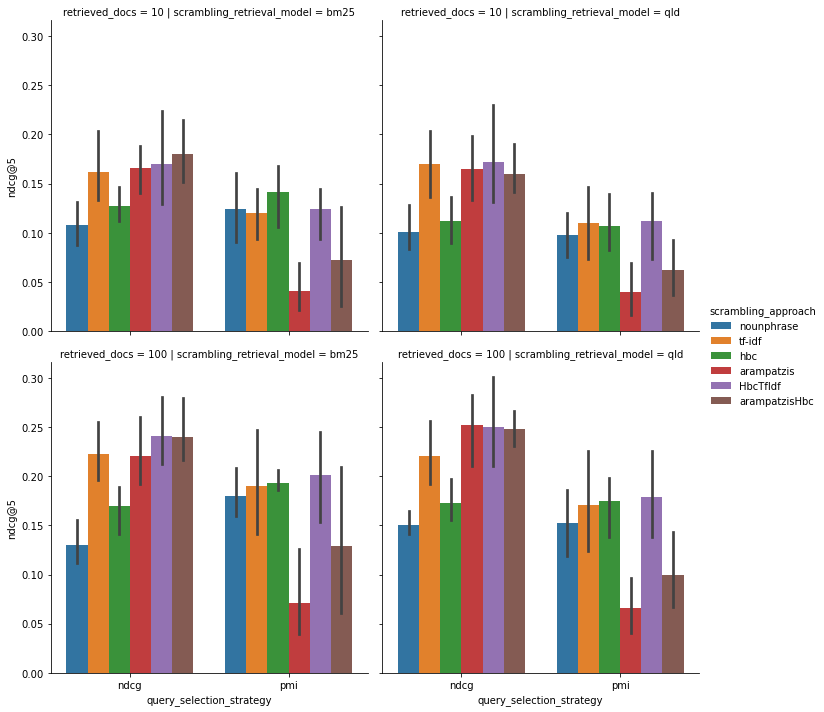

In [27]:
sns.catplot(data=df[(df['query_selection_strategy'] == 'ndcg') | (df['query_selection_strategy'] == 'pmi')],  x='query_selection_strategy', y='ndcg@5', col='scrambling_retrieval_model', hue='scrambling_approach', row='retrieved_docs', kind='bar')